In [1]:
import pandas as pd
import numpy as np
import os
import pickle


In [2]:
delim = ';'

base_path = '/opt/iui-datarelease1-sose2021/'

Xpickle_file = './X.pickle'

ypickle_file = './y.pickle'

In [3]:
def shorten(npList):
    temp        = npList['Force']
    thresh      = 100
    leeway      = 5
    
    temps_over_T = np.where(temp > thresh)[0]
    return npList[max(temps_over_T[0]-leeway,0):temps_over_T[-1]+leeway]

In [4]:
def load_pickles():
    _p = open(Xpickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(ypickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [5]:
def load_data():
    if os.path.isfile(Xpickle_file) and os.path.isfile(ypickle_file):
        return load_pickles()
    data = []
    label = []
    for user in range(0, user_count):
        user_path = base_path + str(user) + '/split_letters_csv/'
        for file in os.listdir(user_path):
            file_name = user_path + file
            letter = ''.join(filter(lambda x: x.isalpha(), file))[0]
            data.append(pd.read_csv(file_name, delim))
            label.append(letter)
    return (np.asarray(data, dtype=pd.DataFrame), np.asarray(label, dtype=str), np.asarray(file_name))

In [6]:
%%time
X, y = load_data()

X.dtype

CPU times: user 2.8 s, sys: 161 ms, total: 2.96 s
Wall time: 2.96 s


dtype('O')

In [7]:
%%time
XX = np.array(list(map(shorten, X)))


CPU times: user 3.12 s, sys: 20.1 ms, total: 3.14 s
Wall time: 3.14 s


<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


**How to fix this error**:
```python
<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
```



[           Millis   Acc1 X   Acc1 Y  Acc1 Z  Acc2 X  Acc2 Y  Acc2 Z  Gyro X  \
108  1.559648e+12  -8450.0  13086.0 -4548.0 -1992.0 -3305.0   981.0   384.0   
109  1.559648e+12  -8006.0  12109.0 -4724.0 -2190.0 -3093.0   874.0   475.0   
110  1.559648e+12  -7676.0  11804.0 -3880.0 -2407.0 -2849.0   879.0   561.0   
111  1.559648e+12  -7604.0  11928.0 -4587.0 -2513.0 -2978.0  1004.0   580.0   
112  1.559648e+12  -7434.0  12796.0 -3926.0 -2728.0 -2989.0  1030.0   614.0   
..            ...      ...      ...     ...     ...     ...     ...     ...   
175  1.559648e+12  -6502.0  17157.0 -5903.0 -1094.0 -3943.0   -69.0   306.0   
176  1.559648e+12 -10394.0  20632.0 -5614.0   -29.0 -4922.0   584.0   590.0   
177  1.559648e+12  -9342.0  21390.0 -5431.0   871.0 -5150.0  1533.0   612.0   
178  1.559648e+12  -7897.0  20951.0 -5580.0   557.0 -4971.0  1307.0   562.0   
179  1.559648e+12  -6954.0  19025.0 -4719.0   -98.0 -4448.0   807.0   588.0   

     Gyro Y  Gyro Z  Mag X  Mag Y  Mag Z  Force   

count    13102.000000
mean        61.169058
std         30.698514
min         10.000000
50%         57.000000
95%        102.000000
96%        107.000000
97%        113.000000
98%        127.000000
99%        156.000000
max       1522.000000
dtype: float64

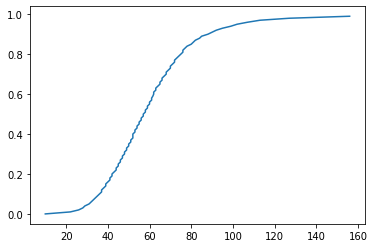

In [8]:
import matplotlib.pyplot as plt
print (XX)
X_len = np.asarray(list(map(len, XX)))
l = []
sq_xlen = pd.Series(X_len)
ptiles = [x*0.01 for x in range(100)]
for i in ptiles:
    l.append(sq_xlen.quantile(i))
    print(l)
plt.plot(l, ptiles)
sq_xlen.describe(percentiles=[x*0.01 for x in range(95,100)])

In [9]:
def plot_data(data):
    fig, axs = plt.subplots(4, 3, figsize=(3*3, 3*4))
    t = data['Millis']
    axs[0][0].plot(t, data['Acc1 X'])
    axs[0][1].plot(t, data['Acc1 Y'])
    axs[0][2].plot(t, data['Acc1 Z'])
    axs[1][0].plot(t, data['Acc2 X'])
    axs[1][1].plot(t, data['Acc2 Y'])
    axs[1][2].plot(t, data['Acc2 Z'])
    axs[2][0].plot(t, data['Gyro X'])
    axs[2][1].plot(t, data['Gyro Y'])
    axs[2][2].plot(t, data['Gyro Z'])
    axs[3][0].plot(t, data['Mag X'])
    axs[3][1].plot(t, data['Mag Y'])
    axs[3][2].plot(t, data['Mag Z'])

    for a in axs:
        for b in a:
            b.plot(t, data['Force'])


In [10]:
threshold_p = 0.99
threshold = int(sq_xlen.quantile(threshold_p))
len_mask = np.where(X_len <= threshold)

X_filter = XX[len_mask]
y_filter = y[len_mask]

X_filter.shape, X_filter[0].shape

((12974,), (72, 15))

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
a = [x.drop(labels='Millis', axis=1) for x in X_filter]

In [12]:
X_filter = pad_sequences(X_filter, dtype=float, padding='post')

In [13]:
def plot_data(data):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data[0])
    axs[0][1].plot(data[1])
    axs[0][2].plot(data[2])
    axs[1][0].plot(data[3])
    axs[1][1].plot(data[4])
    axs[1][2].plot(data[5])
    axs[2][0].plot(data[6])
    axs[2][1].plot(data[7])
    axs[2][2].plot(data[8])
    axs[3][0].plot(data[9])
    axs[3][1].plot(data[10])
    axs[3][2].plot(data[11])
    axs[4][0].plot(data[12])
    axs[4][1].plot(data[13])

#     for a in axs:
#         for b in a:
#             b.plot(t, data['Force'])


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf

lb = LabelBinarizer()

yt_filter = lb.fit_transform(y_filter)

(10379, 156, 15)
(2595, 156, 15)
(10379, 26)
(2595, 26)


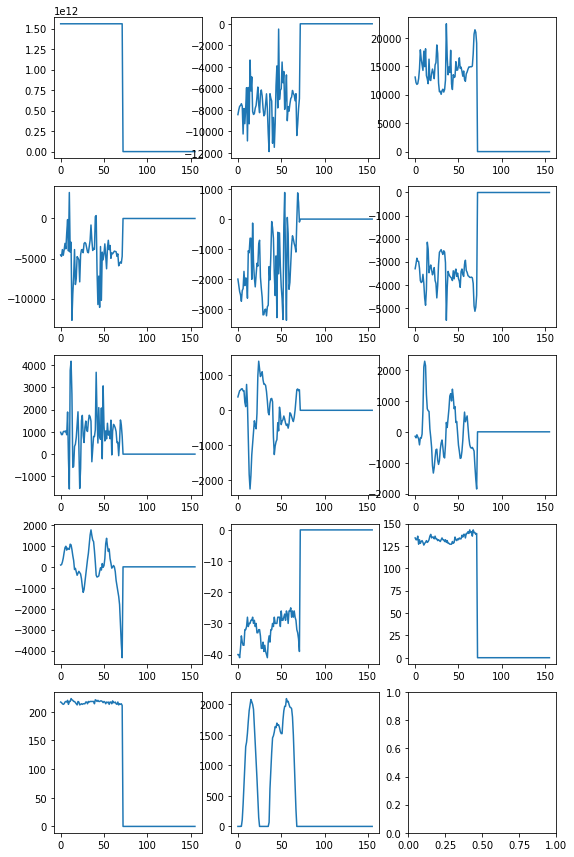

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_filter, yt_filter, test_size=0.2, random_state=177013)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plot_data(X_filter[0].T)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

model = Sequential()

model.add(Flatten(input_shape=X_filter[0].shape))

model.add(BatchNormalization())

model.add(Dense(1560, activation='relu'))

model.add(Dense(750, activation='relu'))

model.add(Dense(300, activation='relu'))

model.add(Dense(156, activation='relu'))

model.add(Dense(26, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy", 
    metrics=["acc"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2340)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2340)              9360      
_________________________________________________________________
dense (Dense)                (None, 1560)              3651960   
_________________________________________________________________
dense_1 (Dense)              (None, 750)               1170750   
_________________________________________________________________
dense_2 (Dense)              (None, 300)               225300    
_________________________________________________________________
dense_3 (Dense)              (None, 156)               46956     
_________________________________________________________________
dense_4 (Dense)              (None, 26)                4

In [17]:
model.fit(X_train, y_train, 
          epochs=20,
          batch_size=64,
          shuffle=True,
          verbose=1
         )

Epoch 1/20
163/163 [==============================] - 2s 4ms/step - loss: 2.8054 - acc: 0.1758
Epoch 2/20
163/163 [==============================] - 1s 3ms/step - loss: 1.6546 - acc: 0.4853
Epoch 3/20
163/163 [==============================] - 1s 3ms/step - loss: 1.2309 - acc: 0.6210
Epoch 4/20
163/163 [==============================] - 1s 3ms/step - loss: 0.9498 - acc: 0.6970
Epoch 5/20
163/163 [==============================] - 1s 3ms/step - loss: 0.7573 - acc: 0.7576
Epoch 6/20
163/163 [==============================] - 1s 3ms/step - loss: 0.6517 - acc: 0.7947
Epoch 7/20
163/163 [==============================] - 1s 3ms/step - loss: 0.5346 - acc: 0.8296
Epoch 8/20
163/163 [==============================] - 1s 3ms/step - loss: 0.4961 - acc: 0.8433
Epoch 9/20
163/163 [==============================] - 1s 3ms/step - loss: 0.4598 - acc: 0.8598
Epoch 10/20
163/163 [==============================] - 1s 3ms/step - loss: 0.4350 - acc: 0.8617
Epoch 11/20
163/163 [============================

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)

lb.inverse_transform(y_test[:3]), lb.inverse_transform(predictions)

Evaluate on test data
82/82 [==============================] - 0s 2ms/step - loss: 1.4639 - acc: 0.7356
test loss, test acc: [1.4639196395874023, 0.7356454730033875]
Generate predictions for 3 samples
predictions shape: (3, 26)


(array(['N', 'U', 'I'], dtype='<U1'), array(['N', 'U', 'I'], dtype='<U1'))

In [19]:
exit()